## Data Analysis

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
import numpy as np
from datetime import datetime
from data import get_data, extract_date_data
from utils import get_path, load_model_data, month, day_of_week, precip_type
plt.style.use('ggplot')

In [2]:
X, y = get_data(include_date = True)
df = X.copy()
X.drop(columns = ['date'], inplace = True)
df['total'] = y.copy()
df.head()

,date,month,day_of_month,day_of_week,precip_intensity_max,precip_intensity_avg,precip_type,wind_speed_max,wind_speed_avg,gust_max,gust_avg,temp_min,temp_max,temp_avg,temp_day,temp_night,humidity,total
0,2018-02-03,2,3,6,0.1336,0.019,1,3.27,3.25,10.24,4.03,0.18,2.84,1.58,2.84,-3.10,0.83,45
1,2018-02-24,2,24,6,0.0000,0.000,0,8.92,8.92,12.12,8.92,-9.05,-0.76,-5.33,-0.76,-9.69,0.60,34
2,2018-03-03,3,3,6,0.1913,0.014,2,5.05,5.08,11.21,5.79,-7.17,0.50,-3.55,0.50,-2.01,0.86,45
3,2018-02-05,2,5,1,0.0000,0.000,0,7.72,7.74,9.97,7.84,-4.58,-1.02,-2.71,-1.02,-5.55,0.74,47
4,2018-03-05,3,5,1,0.0000,0.000,0,4.75,4.76,6.02,4.81,-1.14,6.35,2.27,6.35,1.42,0.87,42


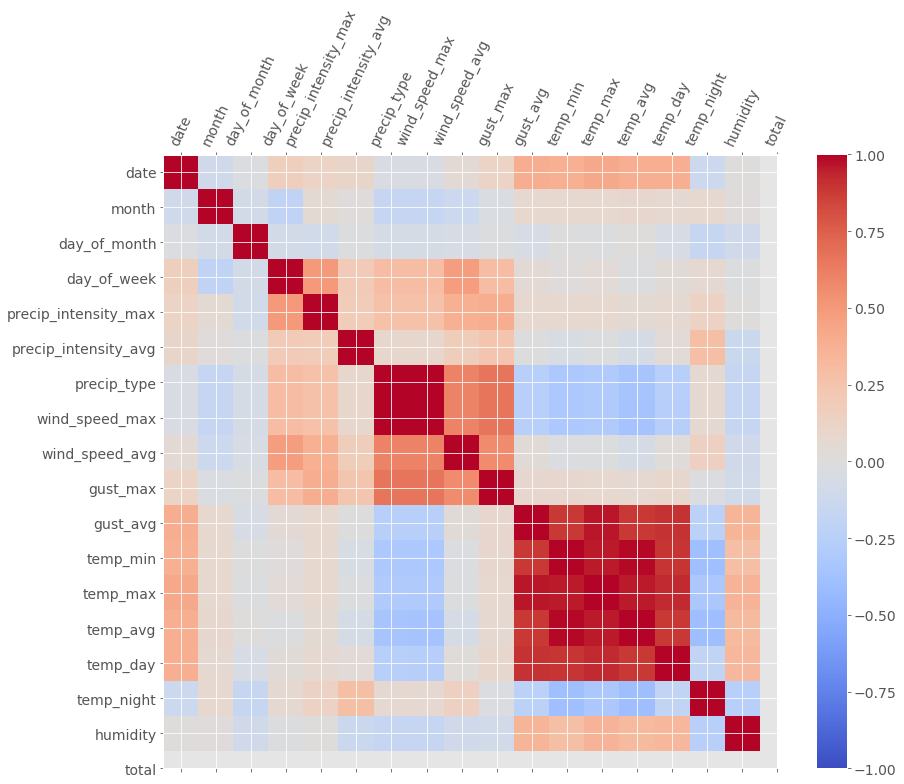

In [3]:
f = plt.figure(figsize = (14, 11))
plt.matshow(df.corr(), fignum = f.number, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=65)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

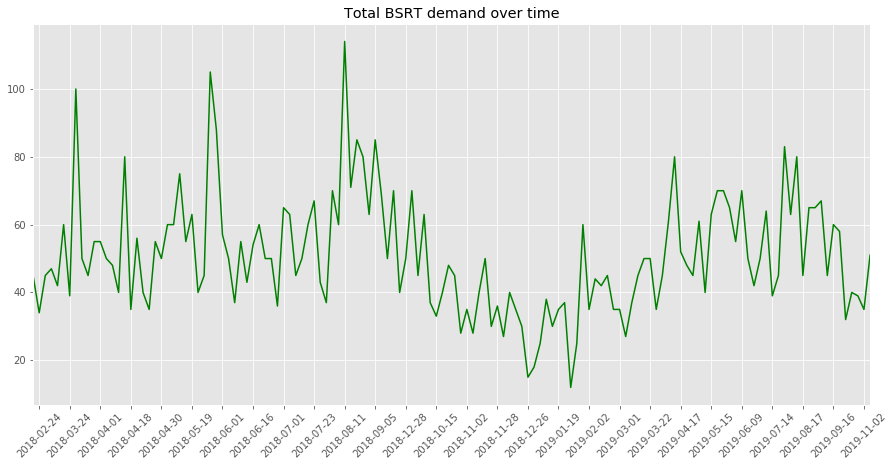

In [4]:
xticks = list(range(1, len(df.index), 5))
ax = df.total.plot(figsize = (15, 7), title = 'Total BSRT demand over time', 
                   rot = 45, xticks = xticks, color = 'g')
ax.set_xticklabels(df.date[xticks])
plt.show()

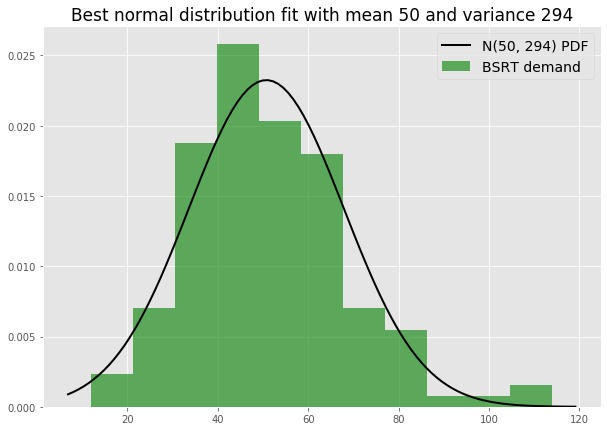

In [5]:
plt.figure(figsize = (10,7))

# Plot the histogram.
plt.hist(df['total'], bins=11, density=True, alpha=0.6, color='g', label = 'BSRT demand')

# Plot the PDF.
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
mu, sigma = norm.fit(df['total'])
pdf = norm.pdf(xs, mu, sigma)
plt.plot(xs, pdf, color = 'k', linewidth = 2, label = f'N({int(mu)}, {int(sigma ** 2)}) PDF')

plt.title(f'Best normal distribution fit with mean {int(mu)} and variance {int(sigma ** 2)}', fontsize = 17)
plt.legend(fontsize = 14)
plt.show()

## Using the model to impute data

In [6]:
weather_df = pd.read_csv(get_path('data') / 'weather_data.tsv', sep = '\t')
weather_df.head()

,date,precip_intensity_max,precip_intensity_avg,precip_type,wind_speed_max,wind_speed_avg,gust_max,gust_avg,temp_min,temp_max,temp_avg,temp_day,temp_night,humidity
0,2018-02-03,0.1336,0.0190,rain,3.27,3.25,10.24,4.03,0.18,2.84,1.58,2.84,-3.10,0.83
1,2018-02-04,0.0129,0.0005,rain,7.07,7.05,11.88,7.28,-3.10,-0.07,-1.50,-0.20,-3.27,0.76
2,2018-02-05,0.0000,0.0000,no_precip,7.72,7.74,9.97,7.84,-4.58,-1.02,-2.71,-1.02,-5.55,0.74
3,2018-02-06,0.0000,0.0000,no_precip,5.84,5.86,6.98,5.88,-5.55,-2.78,-4.15,-2.78,-5.11,0.74
4,2018-02-07,0.0000,0.0000,no_precip,3.62,3.65,5.26,3.74,-5.11,-0.01,-2.72,-0.01,-2.83,0.68


In [7]:
dates = weather_df['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
date_df = extract_date_data(dates)
date_df.head()

,month,day_of_month,day_of_week
0,february,3,saturday
1,february,4,sunday
2,february,5,monday
3,february,6,tuesday
4,february,7,wednesday


In [8]:
pred_df = pd.concat([date_df, weather_df], axis = 1)
prediction_features = [col for col in list(pred_df.columns) if col != 'date']
pred_df.head()

,month,day_of_month,day_of_week,date,precip_intensity_max,precip_intensity_avg,precip_type,wind_speed_max,wind_speed_avg,gust_max,gust_avg,temp_min,temp_max,temp_avg,temp_day,temp_night,humidity
0,february,3,saturday,2018-02-03,0.1336,0.0190,rain,3.27,3.25,10.24,4.03,0.18,2.84,1.58,2.84,-3.10,0.83
1,february,4,sunday,2018-02-04,0.0129,0.0005,rain,7.07,7.05,11.88,7.28,-3.10,-0.07,-1.50,-0.20,-3.27,0.76
2,february,5,monday,2018-02-05,0.0000,0.0000,no_precip,7.72,7.74,9.97,7.84,-4.58,-1.02,-2.71,-1.02,-5.55,0.74
3,february,6,tuesday,2018-02-06,0.0000,0.0000,no_precip,5.84,5.86,6.98,5.88,-5.55,-2.78,-4.15,-2.78,-5.11,0.74
4,february,7,wednesday,2018-02-07,0.0000,0.0000,no_precip,3.62,3.65,5.26,3.74,-5.11,-0.01,-2.72,-0.01,-2.83,0.68


In [9]:
pred_df['month'] = pred_df['month'].map(month)
pred_df['day_of_week'] = pred_df['day_of_week'].map(day_of_week)
pred_df['precip_type'] = pred_df['precip_type'].map(precip_type)
pred_df.head()

,month,day_of_month,day_of_week,date,precip_intensity_max,precip_intensity_avg,precip_type,wind_speed_max,wind_speed_avg,gust_max,gust_avg,temp_min,temp_max,temp_avg,temp_day,temp_night,humidity
0,2,3,6,2018-02-03,0.1336,0.0190,1,3.27,3.25,10.24,4.03,0.18,2.84,1.58,2.84,-3.10,0.83
1,2,4,7,2018-02-04,0.0129,0.0005,1,7.07,7.05,11.88,7.28,-3.10,-0.07,-1.50,-0.20,-3.27,0.76
2,2,5,1,2018-02-05,0.0000,0.0000,0,7.72,7.74,9.97,7.84,-4.58,-1.02,-2.71,-1.02,-5.55,0.74
3,2,6,2,2018-02-06,0.0000,0.0000,0,5.84,5.86,6.98,5.88,-5.55,-2.78,-4.15,-2.78,-5.11,0.74
4,2,7,3,2018-02-07,0.0000,0.0000,0,3.62,3.65,5.26,3.74,-5.11,-0.01,-2.72,-0.01,-2.83,0.68


In [10]:
model = load_model_data()['model']
model

pExtraTreesRegressor(ccp_alpha=0.0, criterion='mse',
                     inbag=array([[2, 0, 0, ..., 0, 0, 0],
       [1, 0, 2, ..., 1, 3, 2],
       [3, 4, 1, ..., 1, 1, 0],
       ...,
       [0, 1, 1, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 2, 1],
       [2, 0, 0, ..., 1, 0, 2]], dtype=int32),
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=5000, n_jobs=-1, ntrain=138, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [11]:
alphas = [0.5, .8, .95, .99]
for alpha in alphas:
    preds, cis = model.predict(pred_df[prediction_features], return_cis = True, alpha = alpha)
    pred_df['prediction'] = preds
    pred_df[round(100 * (1 - alpha) / 2, 1)] = cis[:, 0]
    pred_df[round(100 * ((1 - alpha) / 2 + alpha), 1)] = cis[:, 1]
pred_df.head()

,month,day_of_month,day_of_week,date,precip_intensity_max,precip_intensity_avg,precip_type,wind_speed_max,wind_speed_avg,gust_max,...,humidity,prediction,25.0,75.0,10.0,90.0,2.5,97.5,0.5,99.5
0,2,3,6,2018-02-03,0.1336,0.0190,1,3.27,3.25,10.24,...,0.83,43,41,44,40,46,38,47,37,49
1,2,4,7,2018-02-04,0.0129,0.0005,1,7.07,7.05,11.88,...,0.76,51,48,53,46,56,43,58,41,61
2,2,5,1,2018-02-05,0.0000,0.0000,0,7.72,7.74,9.97,...,0.74,46,44,47,43,48,42,49,41,51
3,2,6,2,2018-02-06,0.0000,0.0000,0,5.84,5.86,6.98,...,0.74,50,47,52,45,55,43,57,40,60
4,2,7,3,2018-02-07,0.0000,0.0000,0,3.62,3.65,5.26,...,0.68,45,43,46,42,47,41,49,39,50


In [12]:
proj_preds = pred_df.copy()[pred_df.date.isin(df.date)]
below_upper = df.total.values <= proj_preds[97.5].values
above_lower = df.total.values >= proj_preds[2.5].values
accuracy = sum(below_upper & above_lower) / len(df)

err_df = proj_preds.copy()
err_df['total'] = df.total.values
above_upper = err_df[~below_upper]
above_err = (above_upper.total - above_upper[97.5]).mean()
below_lower = err_df[~above_lower]
below_err = (below_lower[2.5] - below_lower.total).mean()
off_value = round((above_err + below_err) / 2, 2)

interval_size = (proj_preds[97.5].values - proj_preds[2.5].values).mean()

print(f'{round(accuracy * 100, 2)}% of the demand was within the 95% prediction interval.')
print(f'The values outside the interval were on average {off_value} off.')
print(f'The average length of the 95% prediction interval is {round(interval_size, 2)}.')

81.88% of the demand was within the 95% prediction interval.
The values outside the interval were on average 12.17 off.
The average length of the 95% prediction interval is 17.21.


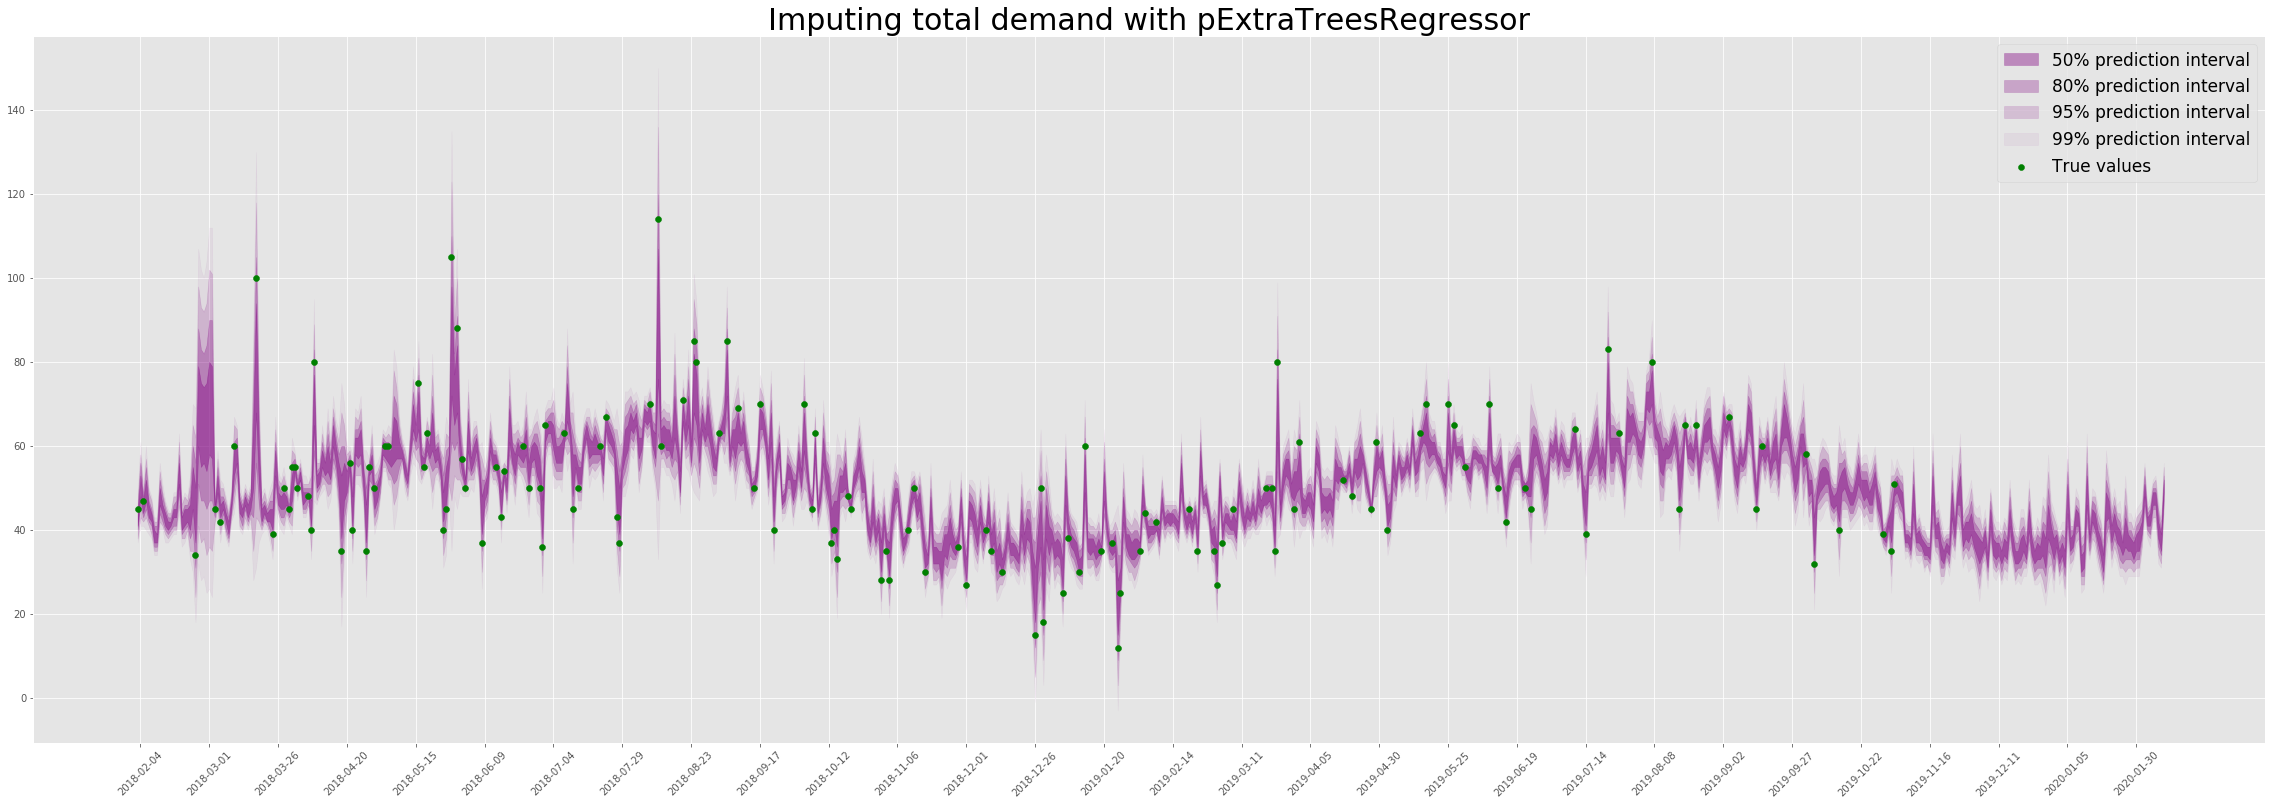

In [13]:
fig, ax = plt.subplots(figsize = (40, 13))

opacities = np.linspace(0.05, 0.4, len(alphas))
for idx, alpha in enumerate(alphas):
    plt.fill_between(pred_df.date, 
                     pred_df[round(100 * (1 - alpha) / 2, 1)], 
                     pred_df[round(100 * ((1 - alpha) / 2 + alpha), 1)],
                     figure = fig, 
                     color = 'purple', 
                     alpha = opacities[-(idx + 1)],
                     label = f'{int(round(alpha * 100))}% prediction interval'
                     )
plt.scatter(df.date, df.total, color = 'green', label = 'True values')
plt.xticks(range(1, len(pred_df.index), 25), 
           pred_df.date[list(range(1, len(pred_df.index), 25))], 
           rotation = 45)
plt.legend(fontsize = 17)
plt.title(f'Imputing total demand with {type(model).__name__}', fontsize = 30)
plt.show()

## Visualising model performance

In [14]:
def earlier_than(date1: str, date2: str):
    from datetime import datetime
    date1, date2 = datetime.strptime(date1, '%Y-%m-%d'), datetime.strptime(date2, '%Y-%m-%d')
    return date1 < date2

In [15]:
def viz_model(cutoff_date = '2019-09-01'):
    train_idxs = [idx for idx, date in zip(df.index, df.date) if earlier_than(date, cutoff_date)]
    
    X_train, X_val = X.iloc[train_idxs, :], X.iloc[list(set(df.index) - set(train_idxs)), :]
    y_train, y_val = y[train_idxs], y[list(set(df.index) - set(train_idxs))]
    idxs = sorted(X_val.index)
    
    fig, ax = plt.subplots(figsize = (15, 7))
    plt.plot(df.date[idxs], df.total[idxs], label = 'True values', color = 'grey')
    
    model = load_model_data()['model'].fit(X_train, y_train)
    for idx, alpha in enumerate(alphas):
        preds, cis = model.predict(X_val, return_cis = True, alpha = alpha)
        plt.fill_between(df.date[idxs], cis[:, 0], cis[:, 1], 
                     figure = fig, color = 'purple', alpha = opacities[-(idx + 1)], 
                         label = f'{round(100 * alpha, 1)}% prediction interval')
    plt.legend(fontsize = 17)
    plt.xticks(rotation = 60)
    plt.title(f'Predictions - {type(model).__name__}', fontsize = 18)  
    
    plt.show()

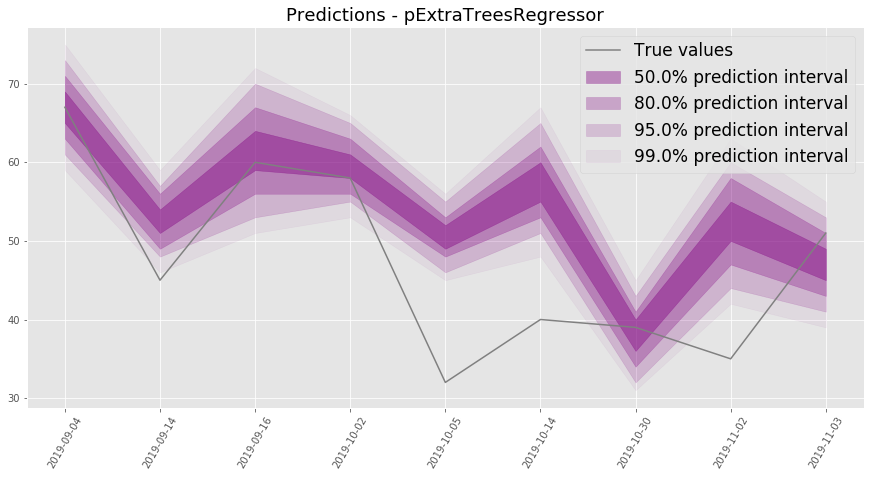

In [16]:
viz_model(cutoff_date = '2019-09-01')